<a href="https://colab.research.google.com/github/fadouaamri/Human_face_generator/blob/main/DataAugRotationOil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#◘acces to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
######################################### Rotation 45 ##########################################
import cv2
import math
def crop_to_center(old_img, new_img):
    """
    Crops `new_img` to `old_img` dimensions
    :param old_img: <numpy.ndarray> or <tuple> dimensions
    :param new_img: <numpy.ndarray>
    :return: <numpy.ndarray> new image cropped to old image dimensions
    """

    if isinstance(old_img, tuple):
        original_shape = old_img
    else:
        original_shape = old_img.shape
    original_width = original_shape[1]
    original_height = original_shape[0]
    original_center_x = original_shape[1] / 2
    original_center_y = original_shape[0] / 2

    new_width = new_img.shape[1]
    new_height = new_img.shape[0]
    new_center_x = new_img.shape[1] / 2
    new_center_y = new_img.shape[0] / 2

    new_left_x = int(max(new_center_x - original_width / 2, 0))
    new_right_x = int(min(new_center_x + original_width / 2, new_width))
    new_top_y = int(max(new_center_y - original_height / 2, 0))
    new_bottom_y = int(min(new_center_y + original_height / 2, new_height))

    # create new img canvas
    canvas = np.zeros(original_shape)

    left_x = int(max(original_center_x - new_width / 2, 0))
    right_x = int(min(original_center_x + new_width / 2, original_width))
    top_y = int(max(original_center_y - new_height / 2, 0))
    bottom_y = int(min(original_center_y + new_height / 2, original_height))

    canvas[top_y:bottom_y, left_x:right_x] = new_img[new_top_y:new_bottom_y, new_left_x:new_right_x]

    return canvas
def rotate_point(origin, point, angle):

    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def rotate_annotation(origin, x_center,y_center,w,h, degree):


    x = x_center * 640
    y = y_center * 640


    angle = math.radians(degree)
    origin_x, origin_y = origin
    origin_y *= -1


    new_x, new_y = map(lambda x: round(x * 2) / 2, rotate_point((origin_x, origin_y), (x, -y), angle))

    new_final_x = new_x /640
    new_final_y = -new_y /640

    width = w * 640
    height = h * 640

    left_x = x - width / 2
    right_x = x + width / 2
    top_y = y - height / 2
    bottom_y = y + height / 2

    c1 = (left_x, top_y)
    c2 = (right_x, top_y)
    c3 = (right_x, bottom_y)
    c4 = (left_x, bottom_y)

    c1 = rotate_point(origin, c1, angle)
    c2 = rotate_point(origin, c2, angle)
    c3 = rotate_point(origin, c3, angle)
    c4 = rotate_point(origin, c4, angle)

    x_coords, y_coords = zip(c1, c2, c3, c4)
    new_final_w = round(max(x_coords) - min(x_coords)) /640
    new_final_h = round(max(y_coords) - min(y_coords)) /640

    return (new_final_x,new_final_y,new_final_w,new_final_h)


In [ ]:
# define the source folder path where the files are located
import numpy as np
import glob
from PIL import Image
import os
import cv2
from keras.utils import load_img, array_to_img, img_to_array
# define the source folder path where the files are located
source_flder_path_images = '/content/drive/MyDrive/Oil/justoil/images/'
label_folder = '/content/drive/MyDrive/Oil/justoil/labels/'

for filename in os.listdir(source_flder_path_images):
    # read the image
    image_path = os.path.join(source_flder_path_images, filename)
    image = cv2.imread(image_path)
    # get dims, find center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)


    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), 45, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    rotated_image45 = cv2.warpAffine(image, M, (nW, nH), False)
    # rotate the image by 90 degrees
    #M45 = cv2.getRotationMatrix2D((cX, cY), 45, 1)
    rotated_image45=crop_to_center(image, rotated_image45)

    # save the rotated image with a new name
    rotated_image_file45 = 'rotate45_' + filename
    rotated_image_path45= os.path.join("/content/drive/MyDrive/Oil/imgr90/images/", rotated_image_file45)
    cv2.imwrite(rotated_image_path45, rotated_image45)
    # read the label file for the original image
    label_file = os.path.splitext(filename)[0] + '.txt'
    label_path = os.path.join(label_folder, label_file)

    ##########################################
    # open the label file and apply the rotation process to each bounding box
    with open(label_path, 'r') as f:
        lines = f.readlines()
    rotated_lines45 = []


    for line in lines:
        parts = line.strip().split()

        # extracting the informations
        x_center = float(parts[1])
        y_center = float(parts[2])
        width = float(parts[3])
        height = float(parts[4])

        origin = (image.shape[1] / 2, image.shape[0] / 2)

        #apply the rotation process to the bounding box coordinates
        x_new45,y_new45,width_new45,height_new45 = rotate_annotation(origin, x_center,y_center,width,height, 45)



        #creating the bounding boxes
        rotated_line45 = [parts[0], str(x_new45), str(y_new45), str(width_new45), str(height_new45)]
        rotated_lines45.append(' '.join(rotated_line45) + '\n')



    # save the new label file with the same name as the rotated image
    rotated_label_file45 = 'rotate45_' + label_file
    rotated_label_path45 = os.path.join("/content/drive/MyDrive/Oil/imgr90/labels/", rotated_label_file45)
    with open(rotated_label_path45, 'w') as f:
      f.writelines(rotated_lines45)







In [ ]:
import cv2
with open("/content/drive/MyDrive/Oil/imgr90/labels/rotate45_Oil0003.txt", 'r') as f:
        lines = f.readlines()
        for line in lines:
          parts = line.strip().split()

          # extracting the informations
          x_center = float(parts[1])
          y_center = float(parts[2])
          width = float(parts[3])
          height = float(parts[4])
          print(x_center,y_center,width,height)


0.50703125 0.503125 0.9484375 0.9484375


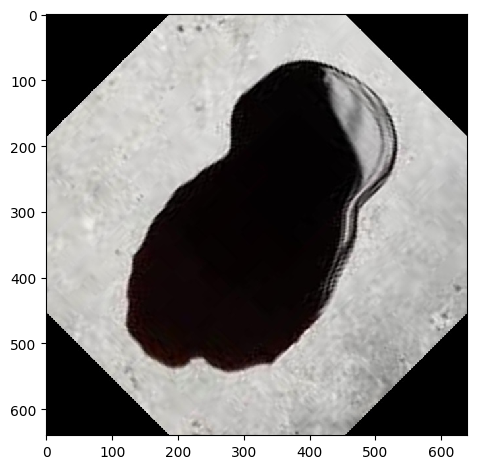

In [ ]:
from skimage.io import imread
import matplotlib.patches as patches
import numpy as np
img_path = "/content/drive/MyDrive/Oil/imgr90/images/rotate45_Oil0003.jpg"
image = cv2.imread(img_path)
im = imread(img_path).astype(np.float64) / 255
from skimage import data, io
from matplotlib import pyplot as plt
fig,ax = plt.subplots(1)






io.imshow(im)
rect = patches.Rectangle((320*0.50703125,320*0.503125),0,0,linewidth=5,edgecolor='b',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()






In [ ]:
######################################### Rotation 90 ##########################################
# define the source folder path where the files are located
import numpy as np
import glob
from PIL import Image
import os
import cv2
from keras.utils import load_img, array_to_img, img_to_array
# define the source folder path where the files are located
source_flder_path_images = '/content/drive/MyDrive/Oil/justoil/images/'
label_folder = '/content/drive/MyDrive/Oil/justoil/labels/'

for filename in os.listdir(source_flder_path_images):
    # read the image
    image_path = os.path.join(source_flder_path_images, filename)
    image = cv2.imread(image_path)
    # get dims, find center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)


    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), 90, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    rotated_image90 = cv2.warpAffine(image, M, (nW, nH), False)
    # rotate the image by 90 degrees
    #M45 = cv2.getRotationMatrix2D((cX, cY), 45, 1)
    rotated_image90=crop_to_center(image, rotated_image90)

    # save the rotated image with a new name
    rotated_image_file90 = 'rotate90_' + filename
    rotated_image_path90= os.path.join("/content/drive/MyDrive/Oil/imgr900/images/", rotated_image_file90)
    cv2.imwrite(rotated_image_path90, rotated_image90)
    # read the label file for the original image
    label_file = os.path.splitext(filename)[0] + '.txt'
    label_path = os.path.join(label_folder, label_file)

    ##########################################
    # open the label file and apply the rotation process to each bounding box
    with open(label_path, 'r') as f:
        lines = f.readlines()
    rotated_lines90 = []


    for line in lines:
        parts = line.strip().split()

        # extracting the informations
        x_center = float(parts[1])
        y_center = float(parts[2])
        width = float(parts[3])
        height = float(parts[4])

        origin = (image.shape[1] / 2, image.shape[0] / 2)

        #apply the rotation process to the bounding box coordinates
        x_new90,y_new90,width_new90,height_new90 = rotate_annotation(origin, x_center,y_center,width,height, 90)



        #creating the bounding boxes
        rotated_line90 = [parts[0], str(x_new90), str(y_new90), str(width_new90), str(height_new90)]
        rotated_lines90.append(' '.join(rotated_line90) + '\n')



    # save the new label file with the same name as the rotated image
    rotated_label_file90 = 'rotate90_' + label_file
    rotated_label_path90 = os.path.join("/content/drive/MyDrive/Oil/imgr900/labels/", rotated_label_file90)
    with open(rotated_label_path90, 'w') as f:
      f.writelines(rotated_lines90)


In [ ]:
######################################### Rotation 180 ##########################################
# define the source folder path where the files are located
import numpy as np
import glob
from PIL import Image
import os
import cv2
from keras.utils import load_img, array_to_img, img_to_array
# define the source folder path where the files are located
source_flder_path_images = '/content/drive/MyDrive/Oil/justoil/images/'
label_folder = '/content/drive/MyDrive/Oil/justoil/labels/'

for filename in os.listdir(source_flder_path_images):
    # read the image
    image_path = os.path.join(source_flder_path_images, filename)
    image = cv2.imread(image_path)
    # get dims, find center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)


    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), 180, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    rotated_image180 = cv2.warpAffine(image, M, (nW, nH), False)
    # rotate the image by 90 degrees
    #M45 = cv2.getRotationMatrix2D((cX, cY), 45, 1)
    rotated_image180=crop_to_center(image, rotated_image180)

    # save the rotated image with a new name
    rotated_image_file180 = 'rotate180_' + filename
    rotated_image_path180= os.path.join("/content/drive/MyDrive/Oil/imgr180/images/", rotated_image_file180)
    cv2.imwrite(rotated_image_path180, rotated_image180)
    # read the label file for the original image
    label_file = os.path.splitext(filename)[0] + '.txt'
    label_path = os.path.join(label_folder, label_file)

    ##########################################
    # open the label file and apply the rotation process to each bounding box
    with open(label_path, 'r') as f:
        lines = f.readlines()
    rotated_lines180 = []


    for line in lines:
        parts = line.strip().split()

        # extracting the informations
        x_center = float(parts[1])
        y_center = float(parts[2])
        width = float(parts[3])
        height = float(parts[4])

        origin = (image.shape[1] / 2, image.shape[0] / 2)

        #apply the rotation process to the bounding box coordinates
        x_new180,y_new180,width_new180,height_new180 = rotate_annotation(origin, x_center,y_center,width,height, 180)



        #creating the bounding boxes
        rotated_line180 = [parts[0], str(x_new180), str(y_new180), str(width_new180), str(height_new180)]
        rotated_lines180.append(' '.join(rotated_line180) + '\n')



    # save the new label file with the same name as the rotated image
    rotated_label_file180 = 'rotate180_' + label_file
    rotated_label_path180 = os.path.join("/content/drive/MyDrive/Oil/imgr180/labels/", rotated_label_file180)
    with open(rotated_label_path180, 'w') as f:
      f.writelines(rotated_lines180)


In [ ]:
######################################### Rotation 270 ##########################################
# define the source folder path where the files are located
import numpy as np
import glob
from PIL import Image
import os
import cv2
from keras.utils import load_img, array_to_img, img_to_array
# define the source folder path where the files are located
source_flder_path_images = '/content/drive/MyDrive/Oil/justoil/images/'
label_folder = '/content/drive/MyDrive/Oil/justoil/labels/'

for filename in os.listdir(source_flder_path_images):
    # read the image
    image_path = os.path.join(source_flder_path_images, filename)
    image = cv2.imread(image_path)
    # get dims, find center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)


    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), 270, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    rotated_image270 = cv2.warpAffine(image, M, (nW, nH), False)
    # rotate the image by 2700 degrees

    rotated_image270=crop_to_center(image, rotated_image270)

    # save the rotated image with a new name
    rotated_image_file270 = 'rotate270_' + filename
    rotated_image_path270= os.path.join("/content/drive/MyDrive/Oil/imgr270/images/", rotated_image_file270)
    cv2.imwrite(rotated_image_path270, rotated_image270)
    # read the label file for the original image
    label_file = os.path.splitext(filename)[0] + '.txt'
    label_path = os.path.join(label_folder, label_file)

    ##########################################
    # open the label file and apply the rotation process to each bounding box
    with open(label_path, 'r') as f:
        lines = f.readlines()
    rotated_lines270 = []


    for line in lines:
        parts = line.strip().split()

        # extracting the informations
        x_center = float(parts[1])
        y_center = float(parts[2])
        width = float(parts[3])
        height = float(parts[4])

        origin = (image.shape[1] / 2, image.shape[0] / 2)

        #apply the rotation process to the bounding box coordinates
        x_new270,y_new270,width_new270,height_new270 = rotate_annotation(origin, x_center,y_center,width,height, 270)



        #creating the bounding boxes
        rotated_line270 = [parts[0], str(x_new270), str(y_new270), str(width_new270), str(height_new270)]
        rotated_lines270.append(' '.join(rotated_line270) + '\n')



    # save the new label file with the same name as the rotated image
    rotated_label_file270 = 'rotate270_' + label_file
    rotated_label_path270 = os.path.join("/content/drive/MyDrive/Oil/imgr270/labels/", rotated_label_file270)
    with open(rotated_label_path270, 'w') as f:
      f.writelines(rotated_lines270)

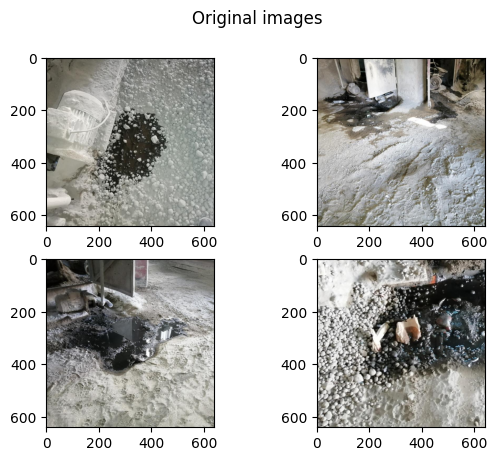

In [ ]:
#orignal images
from skimage import data, io
from matplotlib import pyplot as plt
from skimage.io import imread
source_flder_path_images = '/content/drive/MyDrive/Oil/justoil/images/'
l=[source_flder_path_images+'Oil0002.jpg', source_flder_path_images+'Oil0019.jpg', source_flder_path_images+'Oil0020.jpg', source_flder_path_images+'Oil0022.jpg', source_flder_path_images+'Oil0045.jpg']
images=[]
for filename in l:
    # read the image
    image_path = os.path.join(source_flder_path_images, filename)
    image = cv2.imread(image_path)

    im = imread(image_path).astype(np.float64) / 255
    images.append(im)

#display 4 images
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(images[0])
axarr[0,1].imshow(images[1])
axarr[1,0].imshow(images[2])
axarr[1,1].imshow(images[3])
f.suptitle('Original images')


plt.show()









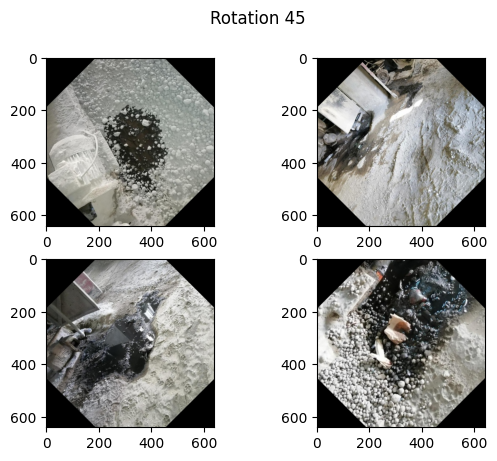

In [ ]:
source_flder_path_images = '/content/drive/MyDrive/Oil/imgr90/images/'
l=[source_flder_path_images+'rotate45_Oil0002.jpg', source_flder_path_images+'rotate45_Oil0019.jpg', source_flder_path_images+'rotate45_Oil0020.jpg', source_flder_path_images+'rotate45_Oil0022.jpg', source_flder_path_images+'rotate45_Oil0045.jpg']
images=[]
for filename in l:
    # read the image
    image_path = os.path.join(source_flder_path_images, filename)
    image = cv2.imread(image_path)

    im = imread(image_path).astype(np.float64) / 255
    images.append(im)

#display 4 images
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(images[0])
axarr[0,1].imshow(images[1])
axarr[1,0].imshow(images[2])
axarr[1,1].imshow(images[3])
f.suptitle('Rotation 45')


plt.show()

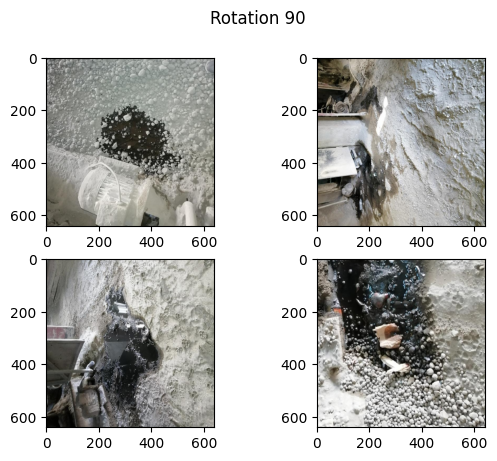

In [ ]:
source_flder_path_images = '/content/drive/MyDrive/Oil/imgr900/images/'
l=[source_flder_path_images+'rotate90_Oil0002.jpg', source_flder_path_images+'rotate90_Oil0019.jpg', source_flder_path_images+'rotate90_Oil0020.jpg', source_flder_path_images+'rotate90_Oil0022.jpg', source_flder_path_images+'rotate90_Oil0045.jpg']
images=[]
for filename in l:
    # read the image
    image_path = os.path.join(source_flder_path_images, filename)
    image = cv2.imread(image_path)

    im = imread(image_path).astype(np.float64) / 255
    images.append(im)

#display 4 images
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(images[0])
axarr[0,1].imshow(images[1])
axarr[1,0].imshow(images[2])
axarr[1,1].imshow(images[3])
f.suptitle('Rotation 90')


plt.show()

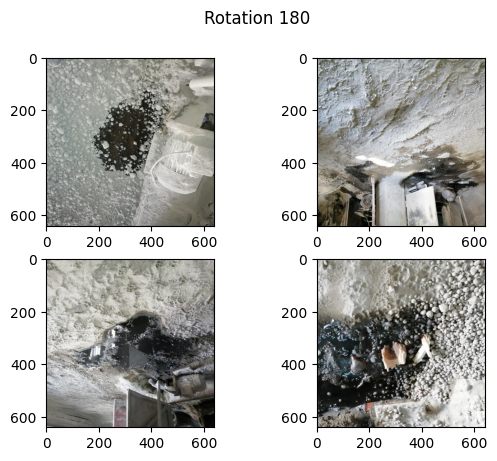

In [ ]:
source_flder_path_images = '/content/drive/MyDrive/Oil/imgr180/images/'
l=[source_flder_path_images+'rotate180_Oil0002.jpg', source_flder_path_images+'rotate180_Oil0019.jpg', source_flder_path_images+'rotate180_Oil0020.jpg', source_flder_path_images+'rotate180_Oil0022.jpg', source_flder_path_images+'rotate180_Oil0045.jpg']
images=[]
for filename in l:
    # read the image
    image_path = os.path.join(source_flder_path_images, filename)
    image = cv2.imread(image_path)

    im = imread(image_path).astype(np.float64) / 255
    images.append(im)

#display 4 images
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(images[0])
axarr[0,1].imshow(images[1])
axarr[1,0].imshow(images[2])
axarr[1,1].imshow(images[3])
f.suptitle('Rotation 180')


plt.show()

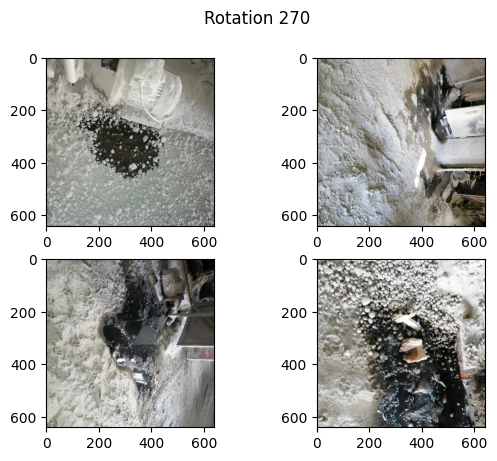

In [ ]:
source_flder_path_images = '/content/drive/MyDrive/Oil/imgr270/images/'
l=[source_flder_path_images+'rotate270_Oil0002.jpg', source_flder_path_images+'rotate270_Oil0019.jpg', source_flder_path_images+'rotate270_Oil0020.jpg', source_flder_path_images+'rotate270_Oil0022.jpg', source_flder_path_images+'rotate270_Oil0045.jpg']
images=[]
for filename in l:
    # read the image
    image_path = os.path.join(source_flder_path_images, filename)
    image = cv2.imread(image_path)

    im = imread(image_path).astype(np.float64) / 255
    images.append(im)

#display 4 images
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(images[0])
axarr[0,1].imshow(images[1])
axarr[1,0].imshow(images[2])
axarr[1,1].imshow(images[3])
f.suptitle('Rotation 270')


plt.show()